In [1]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import sys

# import setGPU
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K

from datetime import datetime
from tensorboard import program
import os
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
from autoencoder_classes import AE,VAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
from losses import mse_split_loss, radius, kl_loss
from functions import make_mse_loss_numpy
from sklearn.metrics import roc_curve, auc


from data_preprocessing import prepare_data
from model import build_AE, build_VAE


def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

In [2]:
input_qcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended/QCD_preprocessed.h5"
input_bsm="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended/BSM_preprocessed.h5"
events = 50000
load_pickle=False
input_pickle='data-for-dnn-v2.pickle'
output_pfile="data.pickle"


if(load_pickle):
    if(input_pickle==''):
        print('Please provide input pickle files')
    with open(input_pickle, 'rb') as f:
        X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler = pickle.load(f)
        bsm_labels=['VectorZPrimeToQQ__M50',
              'VectorZPrimeToQQ__M100',
              'VectorZPrimeToQQ__M200',
              'VBF_HToInvisible_M125',
              'VBF_HToInvisible_M125_private',
              'ZprimeToZH_MZprime1000',
              'ZprimeToZH_MZprime800',
              'ZprimeToZH_MZprime600',
              'GluGluToHHTo4B',
              'HTo2LongLivedTo4mu_1000',
              'HTo2LongLivedTo4mu_125_12',
              'HTo2LongLivedTo4mu_125_25',
              'HTo2LongLivedTo4mu_125_50',
              'VBFHToTauTau',
              'VBF_HH']
else:
    if(input_qcd==''or input_bsm==''):
        print('Please provide input H5 files')
    X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = prepare_data(input_qcd, input_bsm, events, '',True)
    

*** Reading QCD
QCD: (50000, 19, 3)
(25000, 57)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (50000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (50000, 19, 3)
VBF_HToInvisible_M125_private : (50000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
reutrned data


In [3]:
model_type='VAE'
latent_dim=3
batch_size= 1024
n_epochs = 150

if(model_type=='AE'):
    autoencoder = build_AE(X_train_flatten.shape[-1],latent_dim)
    model = AE(autoencoder)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001))

    callbacks=[]
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
    callbacks.append(TerminateOnNaN())
    callbacks.append(NeptuneMonitor())
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

elif(model_type=='VAE'):
    encoder, decoder = build_VAE(X_train_flatten.shape[-1],latent_dim)
    model = VAE(encoder, decoder)
    model.compile(optimizer=keras.optimizers.Adam())

    callbacks=[]
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
    callbacks.append(TerminateOnNaN())
    callbacks.append(NeptuneMonitor())
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

print("Training the model")

history = model.fit(X_train_flatten, X_train_scaled,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=callbacks)


2022-02-10 23:30:41.490353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/uscms/home/abhijith/nobackup/miniconda3/lib/
2022-02-10 23:30:41.490530: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-10 23:30:41.491490: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with t

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 57)          228         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 32)           1856        ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32)          128         ['dense[0][0]']            

saving model to /uscms_data/d3/abhijith/L1AD/l1_anomaly_ae/dnn/model
Saved history to disk
        loss  reconstruction_loss   kl_loss  val_loss  \
60  0.292396             0.290264  0.001984  0.286161   
61  0.292389             0.290429  0.001923  0.285532   
62  0.292879             0.290491  0.001940  0.285463   
63  0.292980             0.290789  0.001951  0.285944   
64  0.290919             0.288846  0.002012  0.286087   

    val_reconstruction_loss  val_kl_loss        lr  epoch  
60                 0.284989     0.001480  0.000001     60  
61                 0.284350     0.001476  0.000001     61  
62                 0.284309     0.001477  0.000001     62  
63                 0.284762     0.001481  0.000001     63  
64                 0.284934     0.001480  0.000001     64  


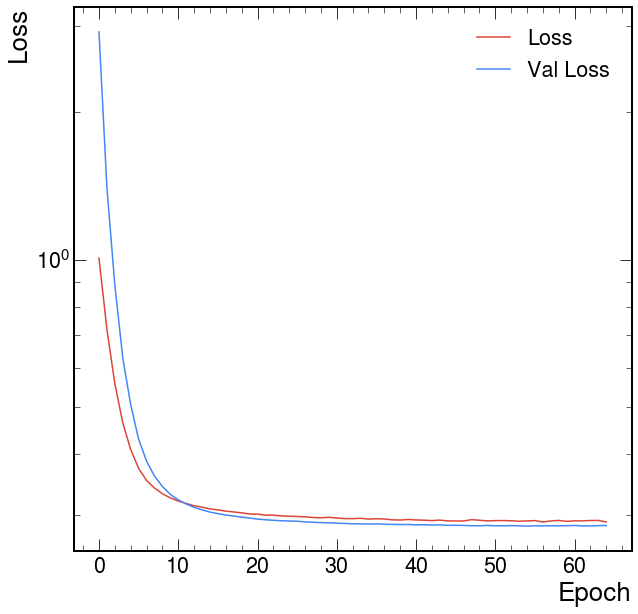

In [4]:
output_model_h5='model.h5'
output_model_json='model.json'
output_history='history.h5'
output_result='results.h5'

if(output_model_h5!=''):
    if(model_type=='VAE'):
        model.save(os.path.join(os.getcwd(),output_model_h5.split('.')[0]))
    else:
        model_json = autoencoder.to_json()
        with open(output_model_json, 'w') as json_file:
            json_file.write(model_json)
        autoencoder.save_weights(output_model_h5)
        print("Saved model to disk")


if(output_history!=''):
    with open(output_history, 'wb') as f:
        pickle.dump(history.history, f)
    print("Saved history to disk")



# Plot training & validation loss values
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())
plt.plot(hist.index.to_numpy(),hist['loss'],label='Loss')
plt.plot(hist.index.to_numpy(),hist['val_loss'],label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.savefig('loss.pdf')
# plt.show()

In [5]:
print("Evaluating the model")
loss = make_mse_loss_numpy
if(model_type=='AE'): 
    qcd_prediction = model.autoencoder(X_test_flatten).numpy()
elif(model_type=='VAE'):
    qcd_mean, qcd_logvar, qcd_z = model.encoder(X_test_scaled)
    qcd_prediction = model.decoder(qcd_z).numpy()


results={}
min_loss,max_loss=1e5,0
for i, label in enumerate(bsm_labels):
    results[label] = {}
    if(model_type=='AE'): 
        bsm_pred = model.autoencoder(bsm_data[i]).numpy()
    elif(model_type=='VAE'): 
        mean_pred, logvar_pred, z_pred = model.encoder(bsm_data[i])
        bsm_pred = decoder(z_pred).numpy()
    results[label]['target'] = bsm_target[i]
    results[label]['prediction'] = bsm_pred
    if(model_type=='VAE'):
        results[label]['mean_prediction'] = mean_pred.numpy()
        results[label]['logvar_prediction'] = logvar_pred.numpy()
        results[label]['z_prediction'] = z_pred.numpy()
        results[label]['kl_loss'] = kl_loss(mean_pred.numpy(),logvar_pred.numpy())

    total_loss = return_total_loss(loss, bsm_target[i], bsm_pred)
    if(np.min(total_loss)<min_loss): min_loss = np.min(total_loss)
    if(np.max(total_loss)>max_loss): max_loss = np.max(total_loss)
    results[label]['loss'] = total_loss
    if(model_type=='VAE'):
        results[label]['total_loss'] = kl_loss(mean_pred.numpy(),z_pred.numpy())+total_loss
        if(np.min(results[label]['total_loss'])<min_loss): min_loss = np.min(total_loss)
        if(np.max(results[label]['total_loss'])>max_loss): max_loss = np.max(total_loss)
        results[label]['radius'] = radius(mean_pred.numpy(),z_pred.numpy())
        

results['QCD'] = {}
results['QCD']['target'] = X_test_scaled
results['QCD']['prediction'] = qcd_prediction
qcd_loss = return_total_loss(loss, X_test_scaled, qcd_prediction)
results['QCD']['loss'] = qcd_loss
if(model_type=='VAE'):
    results['QCD']['mean_prediction'] = qcd_mean.numpy()
    results['QCD']['logvar_prediction'] = qcd_logvar.numpy()
    results['QCD']['z_prediction'] = qcd_z.numpy()
    results['QCD']['kl_loss'] = kl_loss(qcd_mean.numpy(),qcd_logvar.numpy())
    results['QCD']['total_loss']=kl_loss(qcd_mean.numpy(),qcd_logvar.numpy())+qcd_loss
    results['QCD']['radius']=radius(qcd_mean.numpy(),qcd_logvar.numpy())


Evaluating the model


In [6]:
if(output_result!=''):
    h5f = h5py.File(output_result, 'w')
    h5f.create_dataset('loss', data=hist['loss'].to_numpy())
    h5f.create_dataset('val_loss', data=hist['val_loss'].to_numpy())
    h5f.create_dataset('QCD_input', data=X_test_flatten)
    h5f.create_dataset('QCD_target', data=X_test_scaled)
    h5f.create_dataset('predicted_QCD', data = qcd_prediction)
    if(model_type=='VAE'):
        h5f.create_dataset('encoded_mean_QCD', data=qcd_mean.numpy())
        h5f.create_dataset('encoded_logvar_QCD', data=qcd_logvar.numpy())
        h5f.create_dataset('encoded_z_QCD', data=qcd_z.numpy())
    for i, key in enumerate(results):
        if(key=='QCD'): continue
        h5f.create_dataset('%s_scaled' %key, data=results[key]['target'])
        h5f.create_dataset('%s_input' %key, data=bsm_data[i])
        h5f.create_dataset('predicted_%s' %key, data=results[key]['prediction'])
        if(model_type=='VAE'):
            h5f.create_dataset('encoded_mean_%s' %key, data=results[key]['mean_prediction'])
            h5f.create_dataset('encoded_logvar_%s' %key, data=results[key]['logvar_prediction'])
            h5f.create_dataset('encoded_z_%s' %key, data=results[key]['z_prediction'])
    print("*** OutputFile Created")
    h5f.close() 

*** OutputFile Created


In [7]:
min_loss,max_loss=1e5,0
if(model_type=='VAE'):
    min_tloss,max_tloss=1e5,0
    min_r,max_r=1e5,0
for key in results.keys():
    # if(key=='QCD'): continue
    if(np.min(results[key]['loss'])<min_loss): min_loss = np.min(results[key]['loss'])
    if(np.max(results[key]['loss'])>max_loss): max_loss = np.max(results[key]['loss'])
    if(model_type=='VAE'):
        if(np.min(results[key]['total_loss'])<min_tloss): min_tloss = np.min(results[key]['total_loss'])
        if(np.max(results[key]['total_loss'])>max_tloss): max_tloss = np.max(results[key]['total_loss'])
        # if(max_tloss>np.mean(results[key]['total_loss'])+10*np.std(results[key]['total_loss'])): max_tloss = np.mean(results[key]['total_loss'])+10*np.std(results[key]['total_loss'])
        print(key,"Total_loss",np.mean(results[key]['total_loss'])+10*np.std(results[key]['total_loss']))
        if(np.min(results[key]['radius'])<min_r): min_r = np.min(results[key]['radius'])
        if(np.max(results[key]['radius'])>max_r): max_r = np.max(results[key]['radius'])
        # if(max_r>np.mean(results[key]['radius'])+10*np.std(results[key]['radius'])): max_r = np.mean(results[key]['radius'])+10*np.std(results[key]['radius'])
        print(key,"radius",np.mean(results[key]['radius'])+10*np.std(results[key]['radius']))
print(min_loss,max_loss)
print(min_tloss,max_tloss)
print(min_r,max_r)

GluGluToHHTo4B Total_loss 41.13221759101122
GluGluToHHTo4B radius 185.15468913316727
HTo2LongLivedTo4mu_1000 Total_loss 31100.983520069563
HTo2LongLivedTo4mu_1000 radius 2891205370.5
HTo2LongLivedTo4mu_125_12 Total_loss 4135.360767130959
HTo2LongLivedTo4mu_125_12 radius 6271376.5048828125
HTo2LongLivedTo4mu_125_25 Total_loss 12494.6374718186
HTo2LongLivedTo4mu_125_25 radius 13365853.50390625
HTo2LongLivedTo4mu_125_50 Total_loss 4471.298821640235
HTo2LongLivedTo4mu_125_50 radius 87799544983552.0
VBFHToTauTau Total_loss 15.682954271265901
VBFHToTauTau radius 2.223662007600069
VBF_HH Total_loss 35.738572644116324
VBF_HH radius 17.023025929927826
VBF_HToInvisible_M125 Total_loss 8.745081763266018
VBF_HToInvisible_M125 radius 0.31202146457508206
VBF_HToInvisible_M125_private Total_loss 8.76975452853577
VBF_HToInvisible_M125_private radius 0.30558979185298085
VectorZPrimeToQQ__M100 Total_loss 12.642585419912052
VectorZPrimeToQQ__M100 radius 3.41608620621264
VectorZPrimeToQQ__M200 Total_loss 

Plotting the results


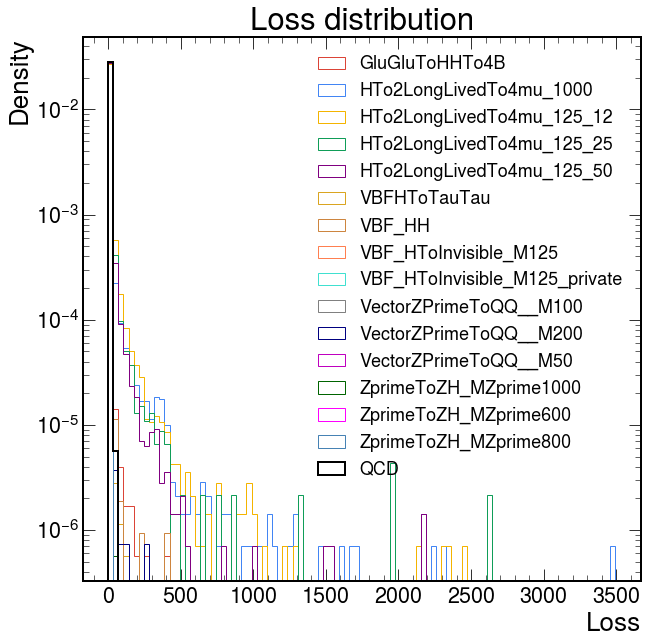

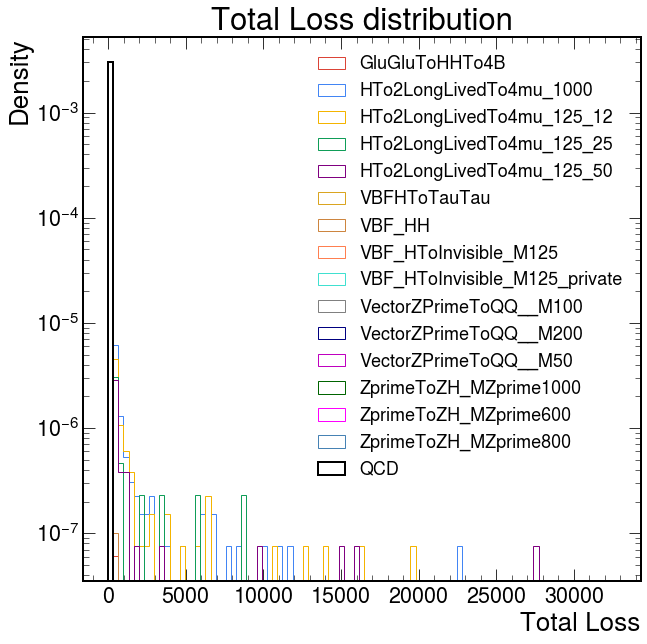

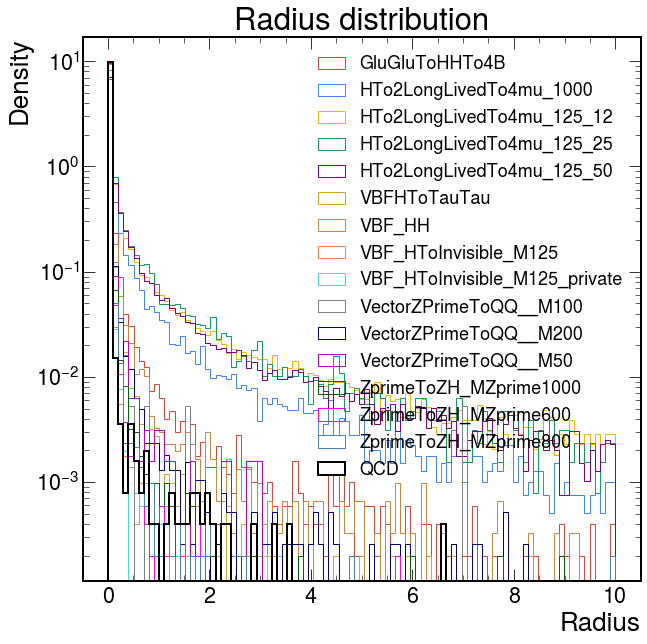

In [12]:
tag='vtest'
print("Plotting the results")
bins_=np.linspace(min_loss,max_loss,100)
plt.figure(figsize=(10,10))
for key in results.keys():
    if(key=='QCD'): plt.hist(results[key]['loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
    else: plt.hist(results[key]['loss'],label=key,histtype='step',bins=bins_,density=True)
plt.legend(fontsize='x-small')
plt.yscale('log')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Loss distribution')
plt.savefig('loss_hist_'+model_type+'_'+tag+'.pdf')
# plt.show()

if(model_type=='VAE'):

    bins_=np.linspace(min_tloss,32673,100)
    plt.figure(figsize=(10,10))
    for key in results.keys():
        if(key=='QCD'): plt.hist(results[key]['total_loss'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
        else: plt.hist(results[key]['total_loss'],label=key,histtype='step',bins=bins_,density=True)
    plt.legend(fontsize='x-small')
    plt.yscale('log')
    plt.xlabel('Total Loss')
    plt.ylabel('Density')
    plt.title('Total Loss distribution')
    plt.savefig('total_loss_hist_'+model_type+'_'+tag+'.pdf')

    bins_=np.linspace(min_r,10,100)
    plt.figure(figsize=(10,10))
    for key in results.keys():
        if(key=='QCD'): plt.hist(results[key]['radius'],label=key,histtype='step',bins=bins_,color='black',linewidth=2,density=True)
        else: plt.hist(results[key]['radius'],label=key,histtype='step',bins=bins_,density=True)
    plt.legend(fontsize='x-small')
    plt.yscale('log')
    plt.xlabel('Radius')
    plt.ylabel('Density')
    plt.title('Radius distribution')
    plt.savefig('radius_hist_'+model_type+'_'+tag+'.pdf')
    
#     for key in results.keys():
#         plt.figure(figsize=(10,10))
#         for i in range(latent_dim):
#             plt.hist(results[key]['mean_prediction'][:,i],bins=100,label='mean '+str(i),histtype='step', density=True,range=[-5,5])
#         plt.legend(fontsize='x-small')
#         plt.xlabel('Loss')
#         plt.ylabel('z')
#         plt.title(key+' mean Z distribution')
#         plt.savefig('mean_z_'+model_type+'_'+key+'_'+tag+'.pdf')
#         # plt.show()

#     for key in results.keys():
#         plt.figure(figsize=(10,10))
#         for i in range(latent_dim):
#             plt.hist(results[key]['logvar_prediction'][:,i],bins=100,label='logvar '+str(i),histtype='step', density=True,range=[-20,20])
#         plt.legend(fontsize='x-small')
#         plt.xlabel('Loss')
#         plt.ylabel('z')
#         plt.title(key+' logvar Z distribution')
#         plt.savefig('logvar_z_'+model_type+'_'+key+'_'+tag+'.pdf')
#         # plt.show()


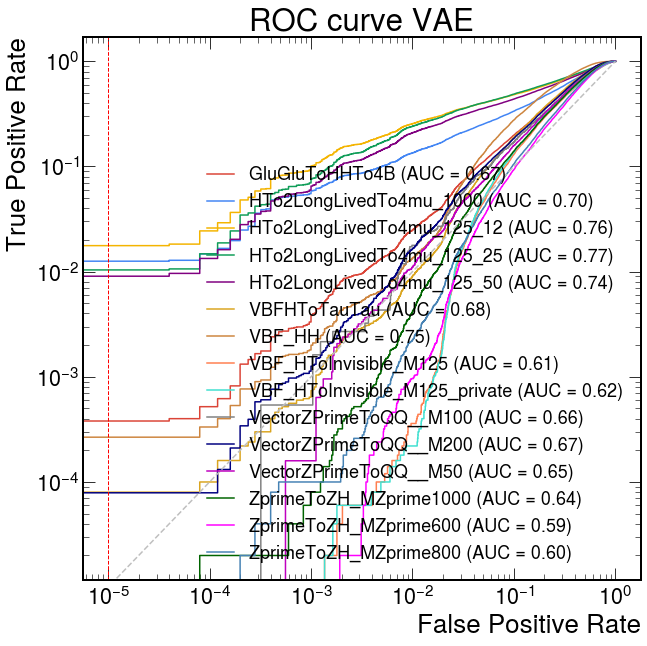

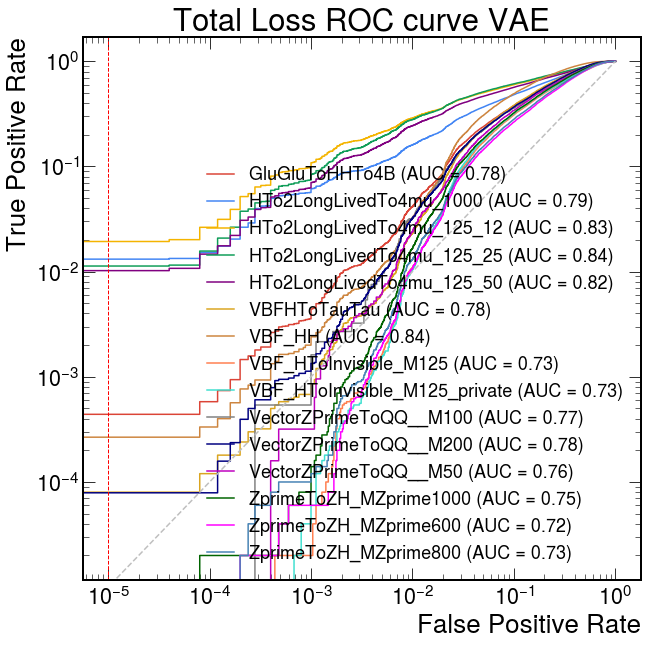

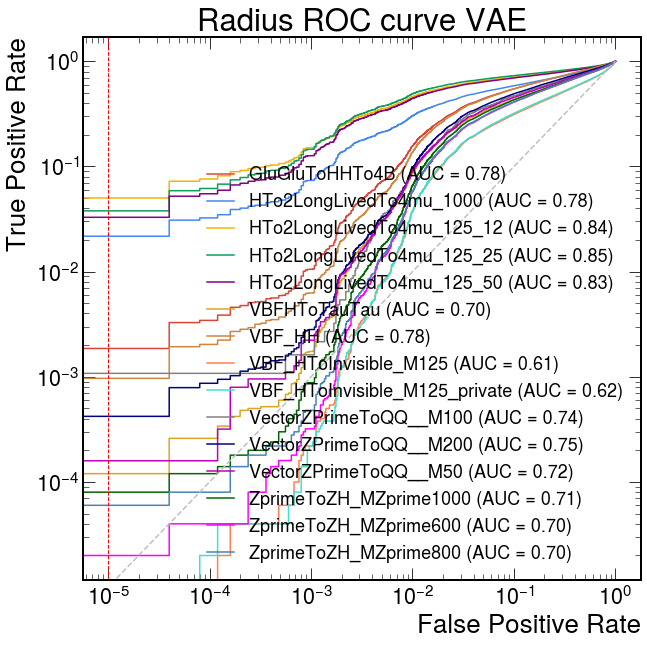

In [9]:
signal_eff={}

plt.figure(figsize=(10,10))
for key in results.keys():
    if key=='QCD': continue
    signal_eff[key]={}
    true_label = np.concatenate(( np.ones(results[key]['target'].shape[0]), np.zeros(results['QCD']['prediction'].shape[0]) ))
    pred_loss = np.concatenate(( results[key]['loss'], results['QCD']['loss'] ))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
    signal_eff[key]['MSE_loss']=tpr_loss[fpr_loss<0.000125][-1]

    auc_loss = auc(fpr_loss, tpr_loss)
    plt.plot(fpr_loss, tpr_loss, label='%s (AUC = %0.2f)' %(key,auc_loss))
plt.legend(fontsize='x-small')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
plt.title('ROC curve '+model_type)
plt.xscale('log')
plt.yscale('log')
plt.savefig('roc_curve_'+model_type+'_'+tag+'.pdf')
# plt.show()

if(model_type=='VAE'):
    plt.figure(figsize=(10,10))
    for key in results.keys():
        if key=='QCD': continue

        true_label = np.concatenate(( np.ones(results[key]['target'].shape[0]), np.zeros(results['QCD']['prediction'].shape[0]) ))
        pred_loss = np.concatenate(( results[key]['total_loss'], results['QCD']['total_loss'] ))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
        signal_eff[key]['KL_loss']=tpr_loss[fpr_loss<0.000125][-1]

        auc_loss = auc(fpr_loss, tpr_loss)
        plt.plot(fpr_loss, tpr_loss, label='%s (AUC = %0.2f)' %(key,auc_loss))
    plt.legend(fontsize='x-small')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
    plt.title('Total Loss ROC curve '+model_type)
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('roc_curve_'+model_type+'_'+tag+'.pdf')
    # plt.show()

    plt.figure(figsize=(10,10))
    for key in results.keys():
        if key=='QCD': continue

        true_label = np.concatenate(( np.ones(results[key]['target'].shape[0]), np.zeros(results['QCD']['prediction'].shape[0]) ))
        pred_loss = np.concatenate(( results[key]['radius'], results['QCD']['radius'] ))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
        signal_eff[key]['radius']=tpr_loss[fpr_loss<0.000125][-1]
        
        
        auc_loss = auc(fpr_loss, tpr_loss)
        plt.plot(fpr_loss, tpr_loss, label='%s (AUC = %0.2f)' %(key,auc_loss))
    plt.legend(fontsize='x-small')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1)
    plt.title('Radius ROC curve '+model_type)
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('roc_curve_'+model_type+'_'+tag+'.pdf')
    # plt.show()
    
signal_eff_pd = pd.DataFrame.from_dict(signal_eff).transpose()

In [10]:
signal_eff_pd

,MSE_loss,KL_loss,radius
GluGluToHHTo4B,0.000620,0.000740,0.003860
HTo2LongLivedTo4mu_1000,0.016637,0.017490,0.034805
HTo2LongLivedTo4mu_125_12,0.029175,0.031425,0.081575
HTo2LongLivedTo4mu_125_25,0.018769,0.020846,0.067923
HTo2LongLivedTo4mu_125_50,0.016175,0.017600,0.059475
VBFHToTauTau,0.000160,0.000180,0.000340
VBF_HH,0.000400,0.000400,0.002233
VBF_HToInvisible_M125,0.000000,0.000000,0.000020
VBF_HToInvisible_M125_private,0.000000,0.000000,0.000040
VectorZPrimeToQQ__M100,0.000000,0.000000,0.001079


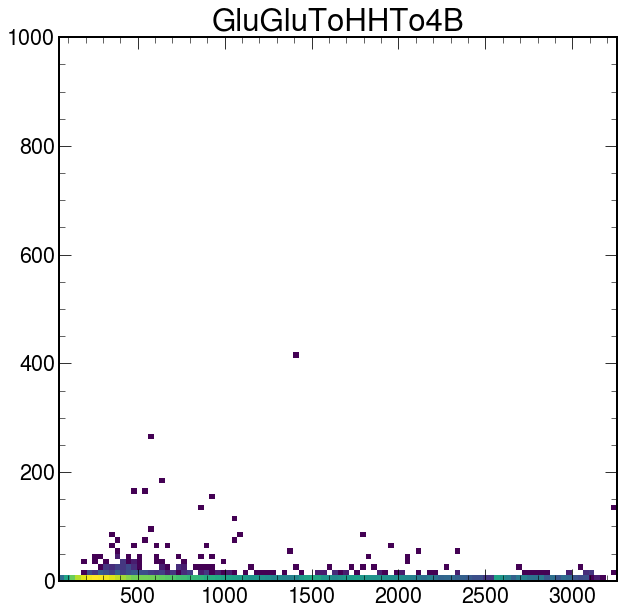

Correlation  GluGluToHHTo4B : 0.09426674895303806


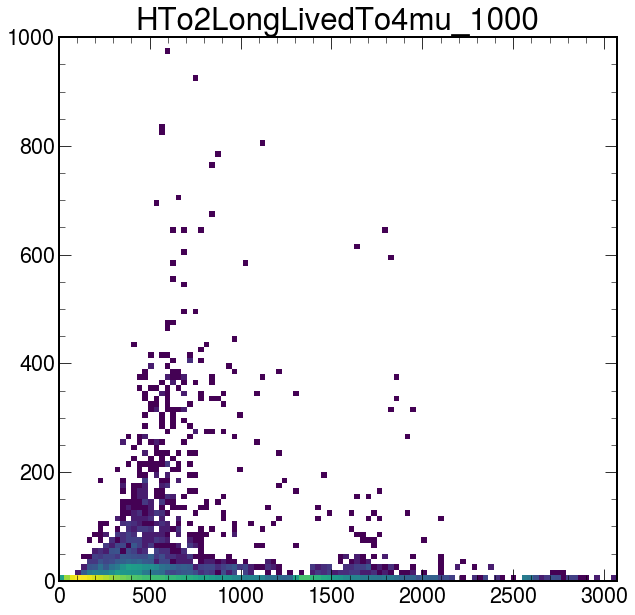

Correlation  HTo2LongLivedTo4mu_1000 : 0.08561627460027764


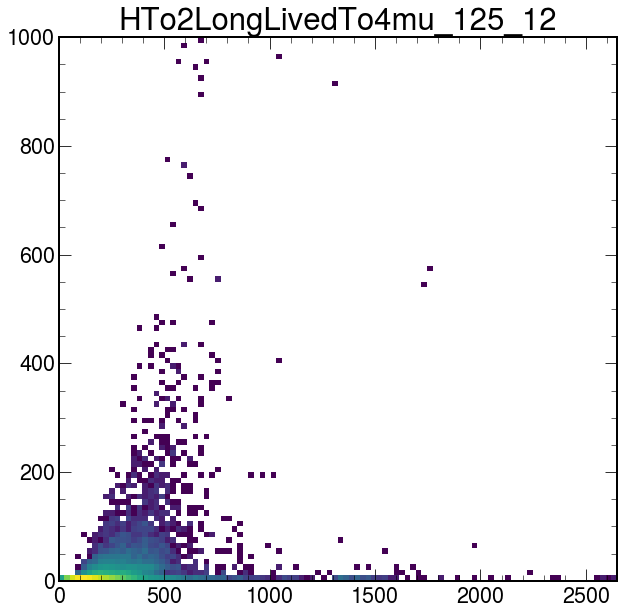

Correlation  HTo2LongLivedTo4mu_125_12 : 0.27095389876473885


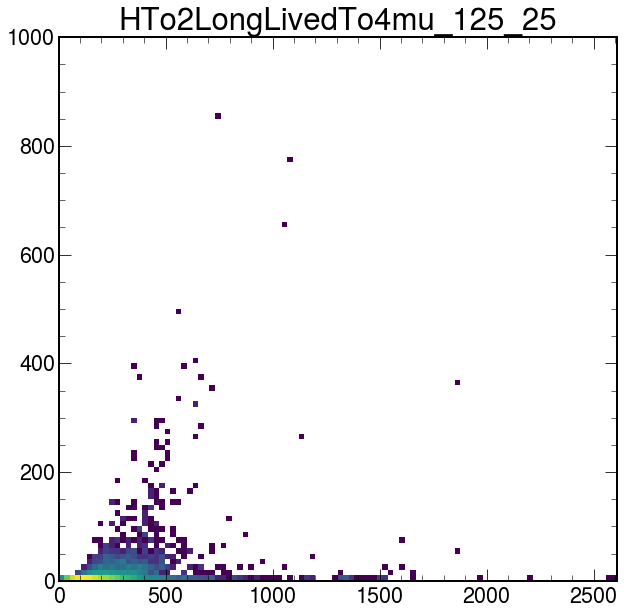

Correlation  HTo2LongLivedTo4mu_125_25 : 0.22083352259848657


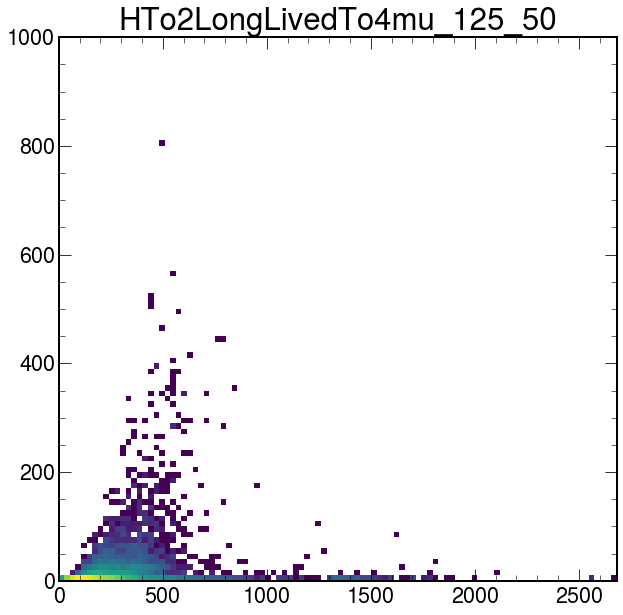

Correlation  HTo2LongLivedTo4mu_125_50 : 0.21505507225843132


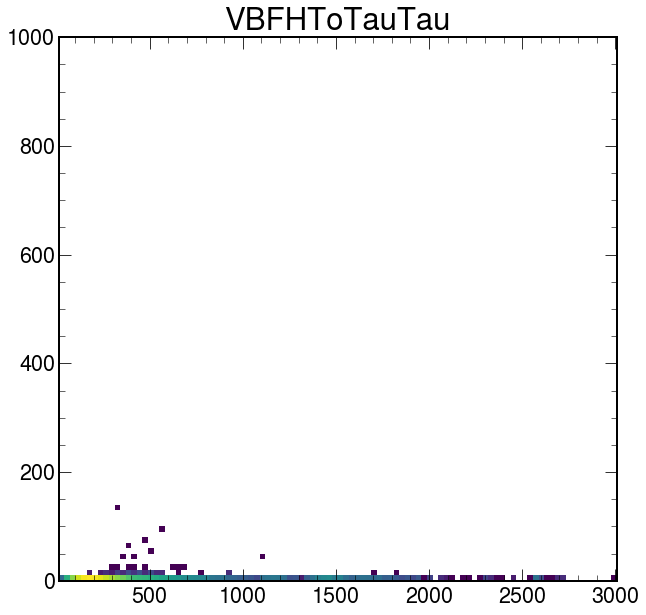

Correlation  VBFHToTauTau : 0.09017328032215893


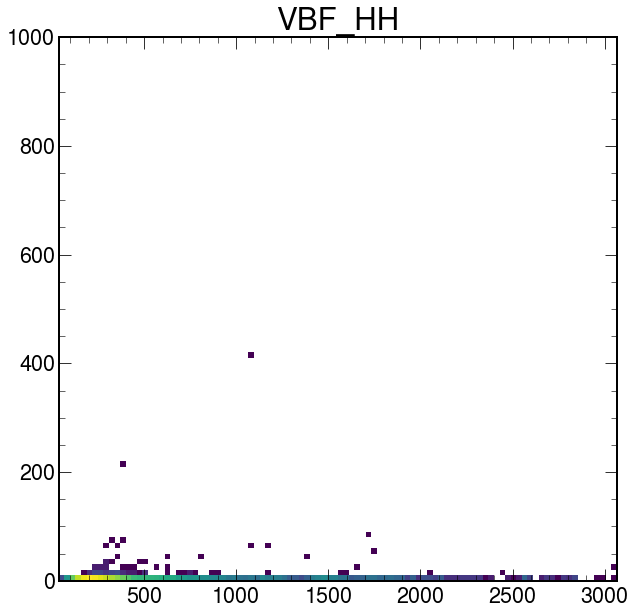

Correlation  VBF_HH : 0.06890084297912227


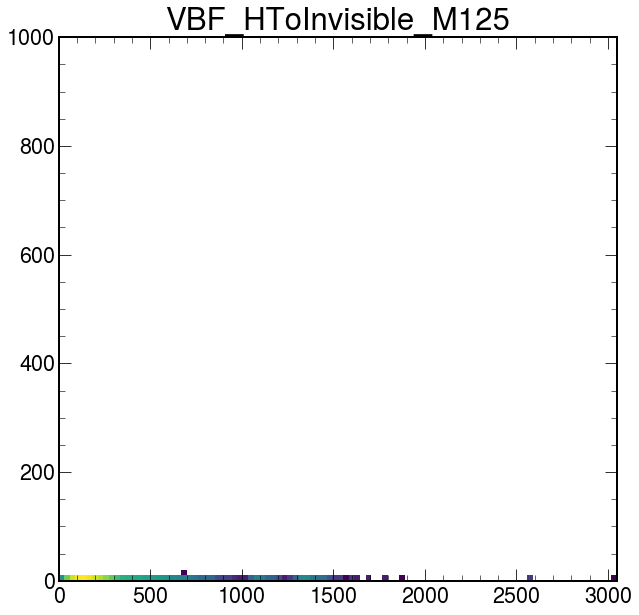

Correlation  VBF_HToInvisible_M125 : 0.11012651074733819


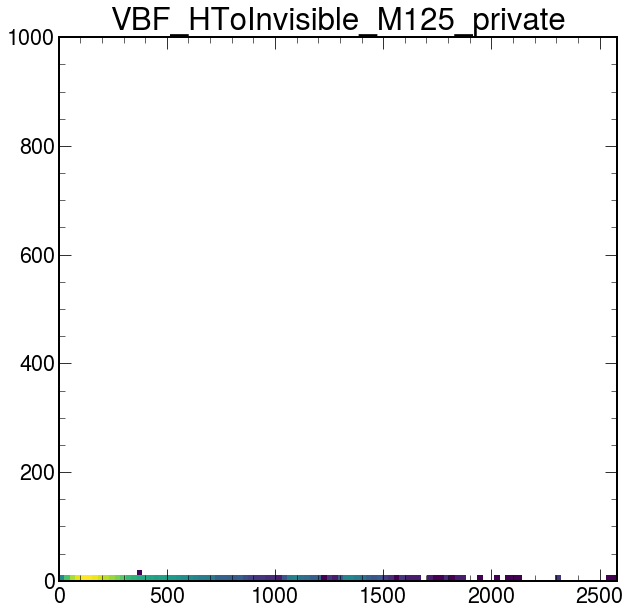

Correlation  VBF_HToInvisible_M125_private : 0.10778662989510407


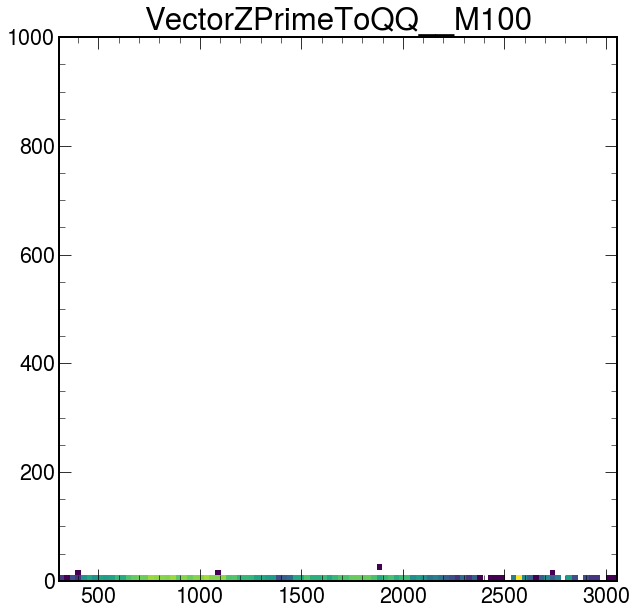

Correlation  VectorZPrimeToQQ__M100 : 0.16512488019478552


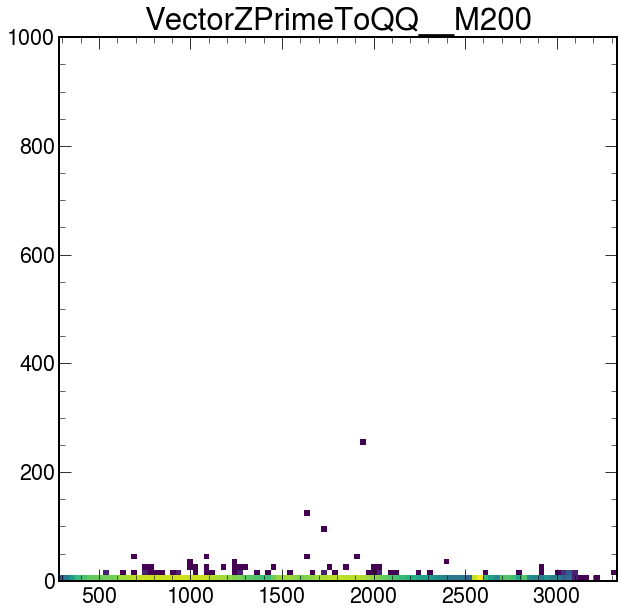

Correlation  VectorZPrimeToQQ__M200 : 0.08665156715290104


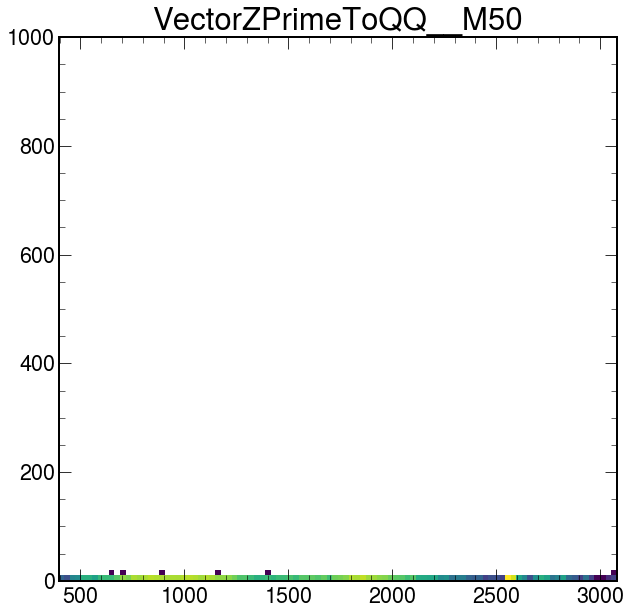

Correlation  VectorZPrimeToQQ__M50 : 0.16671745023277998


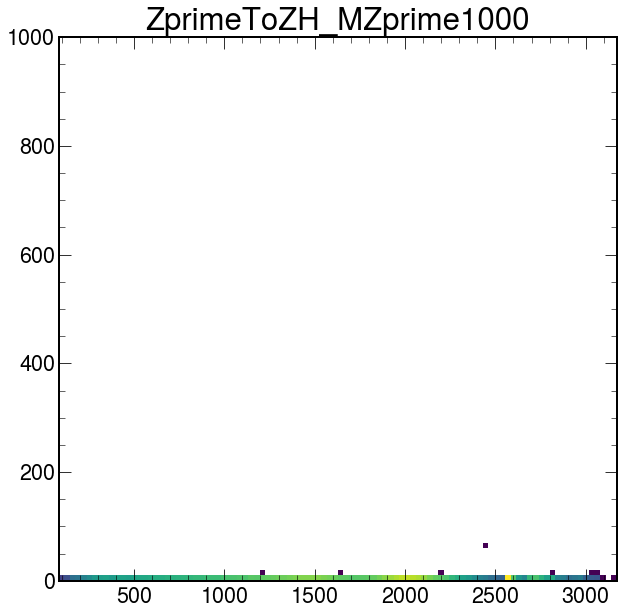

Correlation  ZprimeToZH_MZprime1000 : 0.15915915888770008


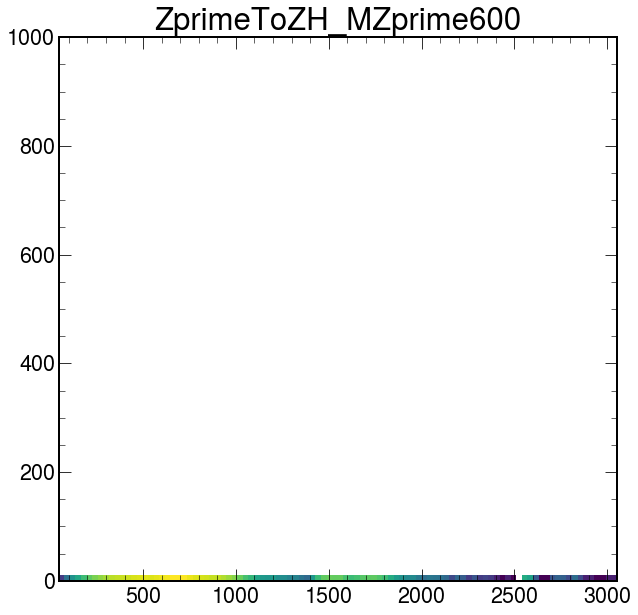

Correlation  ZprimeToZH_MZprime600 : 0.09569322304816166


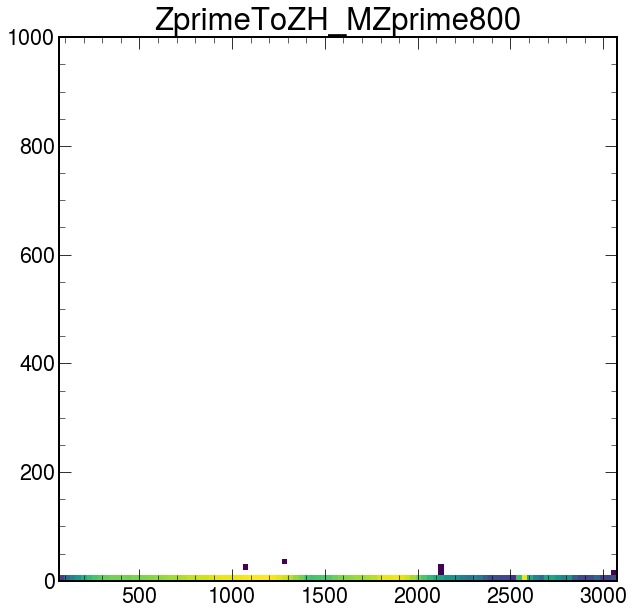

Correlation  ZprimeToZH_MZprime800 : 0.12712510316143366


In [15]:
from scipy.stats import pearsonr
import matplotlib.colors as colors
for i, key in enumerate(results.keys()):
    if key=='QCD': continue
    X_test = bsm_data[i].reshape(bsm_data[i].shape[0],19,3)
    ET_test = np.sum(X_test[:,1:11,0],axis=1)
    _=plt.hist2d(ET_test,results[key]['loss'],bins=(100,100),norm=colors.LogNorm(),range=[[np.min(ET_test),np.max(ET_test)],[0,1000]])
    corr, _ = pearsonr(ET_test, results[key]['loss'])
    plt.title(key)
    plt.show()
    print("Correlation ",key,':' ,corr)

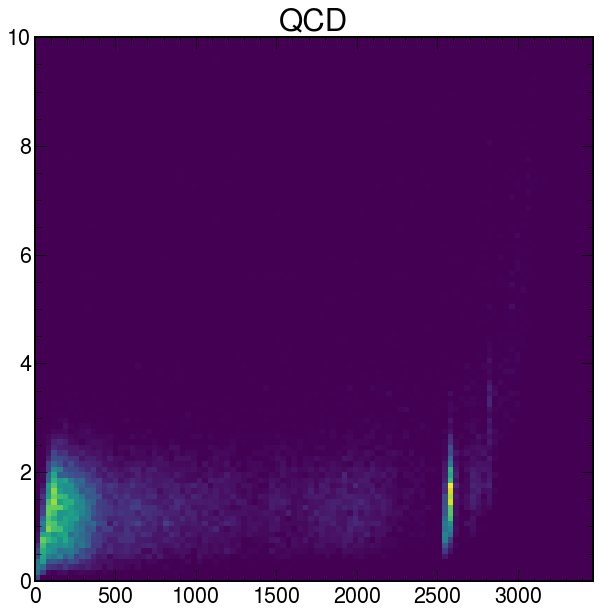

Correlation  QCD : 0.25291691316041576


In [24]:
X_test = X_test_flatten.reshape(X_test_flatten.shape[0],19,3)
ET_test = np.sum(X_test[:,1:11,0],axis=1)
_=plt.hist2d(ET_test,results['QCD']['total_loss'],bins=(100,100),range=[[np.min(ET_test),np.max(ET_test)],[0,10]])
corr, _ = pearsonr(ET_test, results['QCD']['total_loss'])
plt.title(key)
plt.show()
print("Correlation ",key,':' ,corr)